In [1]:
## Import Libraries in this block ##
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from keras import Sequential
from keras import layers
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.models import Model
from keras.datasets import cifar10
from keras.utils import plot_model
from keras.utils import to_categorical
import numpy as np
from PIL import Image 
import os
import pathlib as pl
import sys

from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, concatenate
from tensorflow.keras.models import Model
from keras.applications import ResNet50
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
import sys
import os
prefix = '/content/gdrive/My Drive/'
customized_path = 'DeepLearning'
train_data_dir = 'MidTerm/Data/train_images'
test_data_dir = 'MidTerm/Data/test_images'
sys_path = os.path.join(prefix, customized_path)
train_data_dir = os.path.join(sys_path,train_data_dir)
test_data_dir = os.path.join(sys_path,test_data_dir)
%cd /content/gdrive/MyDrive/DeepLearning
sys.path.append(sys_path)

/content/gdrive/MyDrive/DeepLearning


In [4]:
import pathlib
train_data_dir = pathlib.Path(train_data_dir)
test_data_dir = pathlib.Path(test_data_dir)
image_count = len(list(train_data_dir.glob('*/*.jpg')))
print(image_count)

10843


In [16]:
batch_size = 32
img_height = 64
img_width = 64

In [17]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10843 files belonging to 5 classes.
Using 8675 files for training.


In [18]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10843 files belonging to 5 classes.
Using 2168 files for validation.


In [19]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir,
  image_size=(img_height, img_width))

Found 2398 files belonging to 5 classes.


In [20]:
class_names = train_ds.class_names
print(class_names)

['baseball', 'basketball', 'boxing', 'football', 'volleyball']


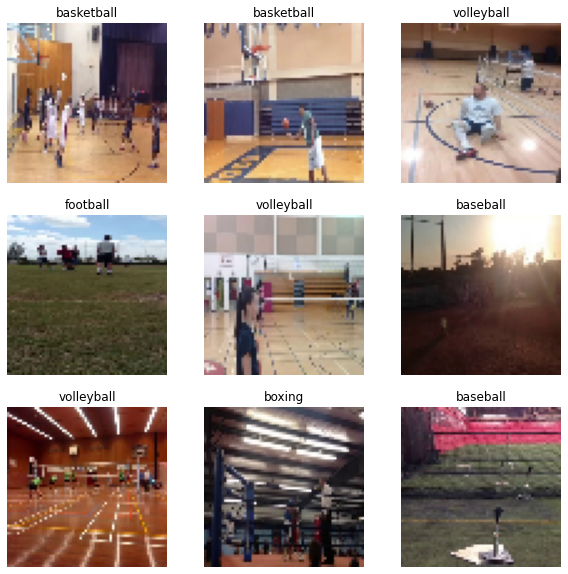

In [38]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [39]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 64, 64, 3)
(32,)


In [21]:
## Normalize Data ##

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Check the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

## Configure for performance ##
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

0.027098654 1.0


In [31]:
##Learning Rate Schedule ##
def lr_schedule(epoch):

    lr = 1e-3
    if epoch > 80:
        lr *= 0.5e-3
    elif epoch > 60:
        lr *= 1e-3
    elif epoch > 40:
        lr *= 1e-2
    elif epoch > 20:
        lr *= 1e-1
        
    print('Learning rate: ', lr)
    return lr

In [42]:
## Funtion to train , test and plot training curve ##

def train_test_plot(model, train_ds,val_ds,test_ds,epochs,batch_size):
  
  
  # Compile model

  model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
  
  # prepare model model saving directory.
  save_dir = os.path.join(os.getcwd(), 'saved_models_mt')
  model_name = 'c10_resnet20_model.{epoch:03d}.h5' 
  if not os.path.isdir(save_dir):
      os.makedirs(save_dir)
  filepath = os.path.join(save_dir, model_name)

  # prepare callbacks for model saving and for learning rate adjustment.
  
  checkpoint = ModelCheckpoint(filepath=filepath,
                               monitor='val_acc',
                               verbose=5,
                               save_best_only=True)

  lr_scheduler = LearningRateScheduler(lr_schedule)

  lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

  callbacks = [checkpoint, lr_reducer, lr_scheduler]
  
  # Train the model 
  history= model.fit(train_ds, batch_size=batch_size,
                        validation_data=val_ds,
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)
 

  # Evaluate Model on Test set
  score = model.evaluate(test_ds,
                       batch_size=batch_size,
                       verbose=2)
  print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))
  
  #Plot training curve
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [43]:
def build_CNN(input_shape,dropout,n_filters,n_layers, num_labels):

  inputs = Input(shape=input_shape)
  x = inputs
  filters = n_filters

  # n layers of Conv2D-Dropout-MaxPooling2D
  # number of filters doubles after each layer (32-64-128)
  for i in range(n_layers):
      x = Conv2D(filters=filters,
                 kernel_size=kernel_size,
                 padding='same',
                 activation='relu')(x)
      x = Dropout(dropout)(x)
      x = MaxPooling2D(pool_size=(2,2))(x)
      filters *= 2
  y = Flatten()(x)
  y = Dropout(dropout)(y)
  outputs = Dense(128, activation='relu')(y)
  outputs = Dense(num_labels, activation='softmax')(y)

  # Build the model (functional API)
  model = Model(inputs, outputs)
  
  return model

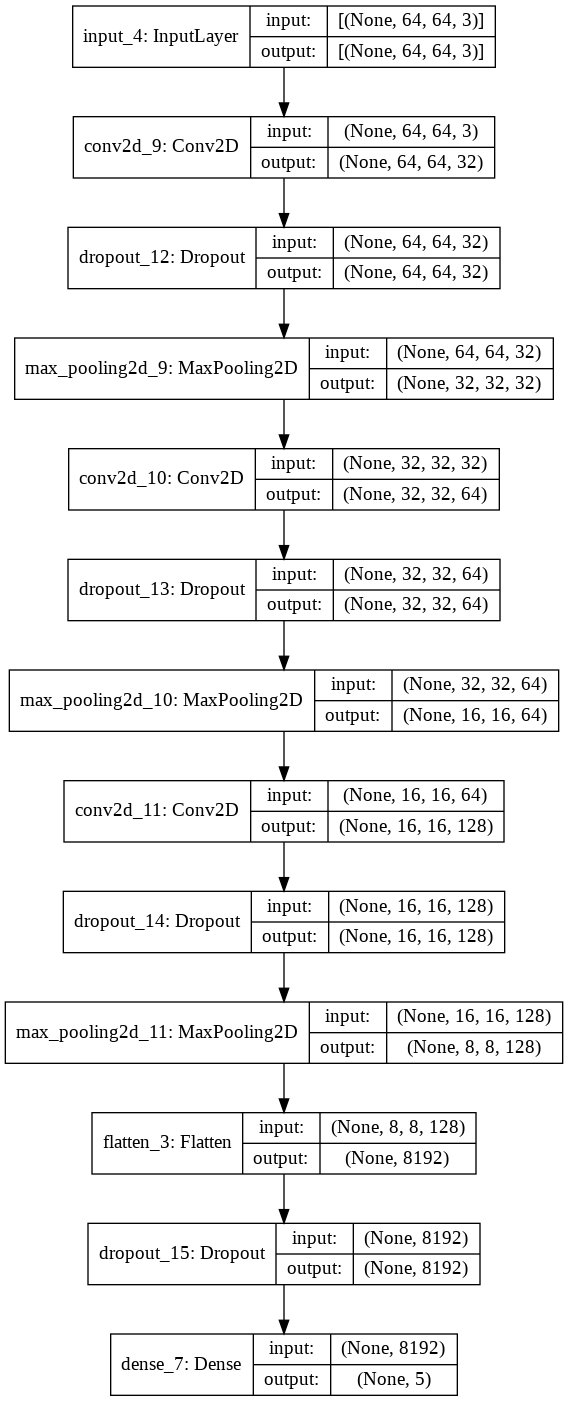

In [44]:
## Network parameters
input_shape=(img_height,img_width,3)
num_labels = len(class_names)
batch_size = 32
kernel_size = (3,3)
dropout = 0.3
n_filters =32
n_layers = 3

model=build_CNN(input_shape,dropout,n_filters,n_layers,num_labels)

# verify the model using graph
# enable this if pydot can be installed
#!pip install pydot
plot_model(model, to_file='cnn-y-network.png', show_shapes=True)


# verify the model using layer text description
#model.summary()

Learning rate:  0.001
Epoch 1/100
Learning rate:  0.001
272/272 [==============================] - 4743s 17s/step - loss: 14.5128 - accuracy: 0.4668 - val_loss: 0.8809 - val_accuracy: 0.7717
Epoch 2/100
Learning rate:  0.001
272/272 [==============================] - 1s 5ms/step - loss: 0.7684 - accuracy: 0.7164 - val_loss: 0.7201 - val_accuracy: 0.8030
Epoch 3/100
Learning rate:  0.001
272/272 [==============================] - 1s 5ms/step - loss: 0.5911 - accuracy: 0.7779 - val_loss: 0.5644 - val_accuracy: 0.8464
Epoch 4/100
Learning rate:  0.001
272/272 [==============================] - 1s 5ms/step - loss: 0.5080 - accuracy: 0.8231 - val_loss: 0.4617 - val_accuracy: 0.8805
Epoch 5/100
Learning rate:  0.001
272/272 [==============================] - 1s 5ms/step - loss: 0.4260 - accuracy: 0.8432 - val_loss: 0.4248 - val_accuracy: 0.8851
Epoch 6/100
Learning rate:  0.001
272/272 [==============================] - 1s 5ms/step - loss: 0.3790 - accuracy: 0.8660 - val_loss: 0.4481 - val_a

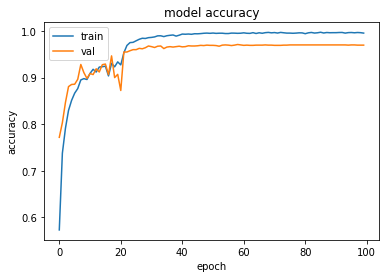

In [45]:
epochs = 100
train_test_plot(model, train_ds,val_ds,test_ds,epochs,batch_size)
model.save('VC_CNN_model_c10.h5')

In [70]:
vgg_model = tf.keras.applications.VGG16(weights='imagenet',
                               include_top=False,
                               input_shape=input_shape)

# Creating dictionary that maps layer names to the layers
layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])

# Getting output tensor of the last VGG layer that we want to include
x = layer_dict['block4_pool'].output

# Stacking a new simple convolutional network on top of it    
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)

# Creating new model. Please note that this is NOT a Sequential() model.
from keras.models import Model
custom_model = Model(inputs=vgg_model.input, outputs=x)
custom_model.summary()
# Make sure that the pre-trained bottom layers are not trainable
for layer in custom_model.layers[:4]:
    layer.trainable = False



Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0  

Learning rate:  0.001
Epoch 1/100
Learning rate:  0.001
272/272 [==============================] - 5s 14ms/step - loss: 22.9368 - accuracy: 0.3468 - val_loss: 1.1777 - val_accuracy: 0.5101
Epoch 2/100
Learning rate:  0.001
272/272 [==============================] - 4s 13ms/step - loss: 1.2397 - accuracy: 0.5018 - val_loss: 0.8594 - val_accuracy: 0.6794
Epoch 3/100
Learning rate:  0.001
272/272 [==============================] - 4s 13ms/step - loss: 0.9253 - accuracy: 0.6493 - val_loss: 0.8427 - val_accuracy: 0.6794
Epoch 4/100
Learning rate:  0.001
272/272 [==============================] - 4s 13ms/step - loss: 0.7238 - accuracy: 0.7192 - val_loss: 0.6591 - val_accuracy: 0.7781
Epoch 5/100
Learning rate:  0.001
272/272 [==============================] - 4s 13ms/step - loss: 0.6102 - accuracy: 0.7772 - val_loss: 0.5316 - val_accuracy: 0.8113
Epoch 6/100
Learning rate:  0.001
272/272 [==============================] - 4s 13ms/step - loss: 0.4630 - accuracy: 0.8365 - val_loss: 0.4949 - va

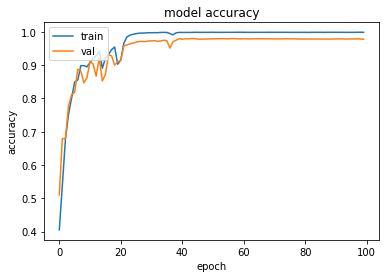

In [71]:
epochs = 100
train_test_plot(custom_model, train_ds,val_ds,test_ds,epochs,batch_size)
model.save('VGG_CNN_model.h5')

In [50]:
## MultiResolution CNN 

def build_MRC_net(input_shape,dropout,n_filters,n_layers, num_labels):
  ## Left branch of Y network
  left_inputs = Input(shape=input_shape)
  x = left_inputs
  filters = n_filters
  # n layers of Conv2D-Dropout-MaxPooling2D
  # number of filters doubles after each layer (32-64-128)
  x = tf.keras.layers.Cropping2D(cropping=((17, 17), (17,17)))(x)
  for i in range(n_layers):
      x = Conv2D(filters=filters,
                 kernel_size=kernel_size,
                 padding='same',
                 activation='relu')(x)
      #x = Dropout(dropout)(x)
      x = MaxPooling2D(pool_size=(2,2))(x)
      x = BatchNormalization()(x)
      filters *= 2

  ## Right branch of Y network
  right_inputs = Input(shape=input_shape)
  y = right_inputs
  filters = n_filters
  # Layers of Conv2D-Dropout-MaxPooling2D
  # Number of filters doubles after each layer (32-64-128)
  y = tf.keras.layers.experimental.preprocessing.Resizing(31,31 , interpolation="bilinear")(y)
  for i in range(n_layers):
      y = Conv2D(filters=filters,
                 kernel_size=kernel_size,
                 padding='same',
                 activation='relu',
                 dilation_rate=2)(y)
      #y = Dropout(dropout)(y)
      y = MaxPooling2D(pool_size=(2,2))(y)
      y = BatchNormalization()(y)
      filters *= 2

  # Merge left and right branches outputs
  y = concatenate([x, y])
  # Feature maps to vector before connecting to Dense 
  y = Flatten()(y)
  y = Dropout(dropout)(y)
  outputs = Dense(num_labels, activation='softmax')(y)

  # Build the model (functional API)
  model = Model([left_inputs, right_inputs], outputs)
  
  return model


In [55]:
## Funtion to train , test and plot training curve For MultiResolution CNN##

def train_test_plot_mrc(model, x_train,y_train,x_val,y_val,x_test,y_test,epochs,batch_size):
  
  
  model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)/10),
              metrics=['accuracy'])
  
  # prepare model model saving directory.
  save_dir = os.path.join(os.getcwd(), 'saved_models_mrc')
  model_name = 'c10_resnet20_model.{epoch:03d}.h5' 
  if not os.path.isdir(save_dir):
      os.makedirs(save_dir)
  filepath = os.path.join(save_dir, model_name)

  # prepare callbacks for model saving and for learning rate adjustment.
  
  checkpoint = ModelCheckpoint(filepath=filepath,
                               monitor='val_acc',
                               verbose=5,
                               save_best_only=True)

  lr_scheduler = LearningRateScheduler(lr_schedule)

  lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

  callbacks = [checkpoint, lr_reducer, lr_scheduler]
  
  #augmented data
  width_shift = 0.1
  height_shift = 0.1
  flip = True

  datagen = ImageDataGenerator(
      featurewise_center=False,
      rotation_range=0.2,
      horizontal_flip=flip,
      width_shift_range=width_shift,
      height_shift_range=height_shift,
      )
  datagen.fit(x_train)
  # Train the model 
  history=model.fit(datagen.flow([x_train,x_train], y_train, batch_size=batch_size),
          steps_per_epoch=len(x_train) / batch_size, epochs=epochs,validation_data= ([x_val,x_val],y_val))

  
  # Evaluate Model on Test set
  score = model.evaluate([x_test, x_test],
                       y_test,
                       batch_size=batch_size,
                       verbose=2)
  print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))
  
  #Plot training curve
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

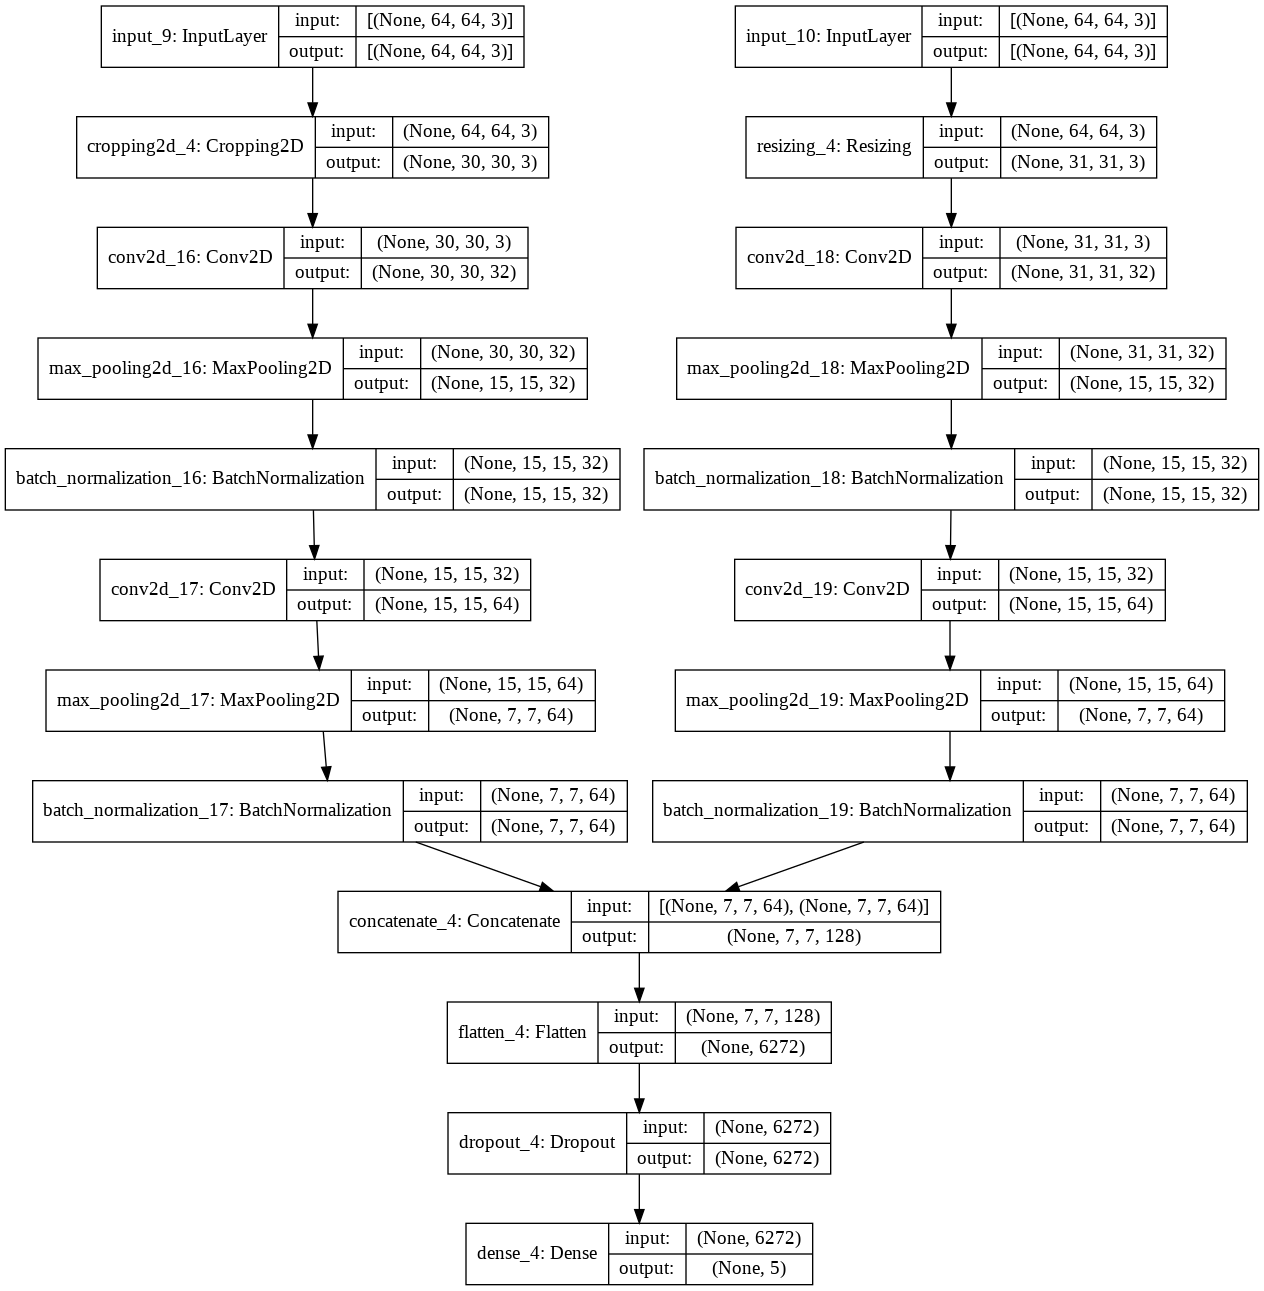

In [52]:
## Network parameters
input_shape=(img_height,img_width,3)
num_labels = len(class_names)
batch_size = 32
kernel_size = (3,3)
dropout = 0.3
n_filters =32
n_layers = 2

model_mrc=build_MRC_net(input_shape,dropout,n_filters,n_layers,num_labels)

# verify the model using graph
# enable this if pydot can be installed
#!pip install pydot
plot_model(model_mrc, to_file='MultiresCNN-network.png', show_shapes=True)


# verify the model using layer text description
#model.summary()

In [53]:
X_train = np.concatenate([X for X, y in train_ds], axis=0)
print(X_train.shape)
y_train = np.concatenate([y for x, y in train_ds], axis=0)
print(y_train.shape)

X_val = np.concatenate([X for X, y in val_ds], axis=0)
print(X_val.shape)
y_val = np.concatenate([y for x, y in val_ds], axis=0)
print(y_val.shape)

X_test = np.concatenate([X for X, y in test_ds], axis=0)
print(X_test.shape)
y_test = np.concatenate([y for x, y in test_ds], axis=0)
print(y_test.shape)


(8675, 64, 64, 3)
(8675,)
(2168, 64, 64, 3)
(2168,)
(2398, 64, 64, 3)
(2398,)


Learning rate:  0.001
Epoch 1/100
271/271 [==============================] - 13s 45ms/step - loss: 1.1257 - accuracy: 0.6616 - val_loss: 0.7138 - val_accuracy: 0.7947
Epoch 2/100
271/271 [==============================] - 12s 44ms/step - loss: 0.4305 - accuracy: 0.8541 - val_loss: 0.6722 - val_accuracy: 0.8040
Epoch 3/100
271/271 [==============================] - 12s 44ms/step - loss: 0.3313 - accuracy: 0.8975 - val_loss: 0.5551 - val_accuracy: 0.8316
Epoch 4/100
271/271 [==============================] - 12s 44ms/step - loss: 0.2336 - accuracy: 0.9203 - val_loss: 0.4805 - val_accuracy: 0.8704
Epoch 5/100
271/271 [==============================] - 12s 45ms/step - loss: 0.2094 - accuracy: 0.9371 - val_loss: 0.3355 - val_accuracy: 0.9124
Epoch 6/100
271/271 [==============================] - 12s 45ms/step - loss: 0.1647 - accuracy: 0.9443 - val_loss: 0.3197 - val_accuracy: 0.9124
Epoch 7/100
271/271 [==============================] - 12s 44ms/step - loss: 0.1919 - accuracy: 0.9342 - val

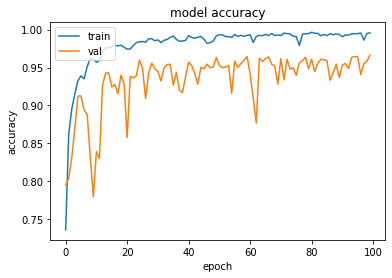

In [54]:
epochs = 100
train_test_plot_mrc(model_mrc, X_train, y_train,X_val,y_val,X_test,y_test,epochs,batch_size)
model.save('MR_CNN_model.h5')